In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scio
import scipy.optimize as opt

In [2]:
def multivariate_gaussian(X, mu, sigma2):
    k = mu.size
    if sigma2.ndim == 1 or (sigma2.ndim == 2 and (sigma2.shape[1] == 1 or sigma2.shape[0] == 1)):
        sigma2 = np.diag(sigma2)
    
    X_new = X - mu
    p = (2 * np.pi) ** (-k / 2) * np.linalg.det(sigma2) ** (-0.5) * np.exp(-0.5 * np.sum(np.dot(X_new, np.linalg.pinv(sigma2)) *X_new, axis=1))

    return p

In [3]:
def visualize_fit(X, mu, sigma2):
    X1, X2 = np.meshgrid(np.arange(0, 35.5, 0.5), np.arange(0, 35.5, 0.5))
    Z = multivariate_gaussian(np.c_[X1.flatten('F'), X2.flatten('F')], mu, sigma2)
    Z = Z.reshape(X1.shape, order='F')

    plt.scatter(X[:, 0], X[:, 1], marker='x', c='b', s=15)

    if np.sum(np.isinf(Z)) == 0:
        plt.contour(X1, X2, Z, levels=10 ** np.arange(-20, 0, 3).astype(np.float))

In [4]:
def compute_numerical_gradient(cost_func, theta):
    numgrad = np.zeros(theta.shape)
    perturb = np.zeros(theta.shape)
    e = 1e-4

    for p in range(theta.shape[0]):
        # Set perturbation vector
        perturb[p] = e
        loss1, _ = cost_func(theta - perturb)
        loss2, _ = cost_func(theta + perturb)

        # Compute Numerical Gradient
        numgrad[p] = (loss2 - loss1) / (2 * e)
        perturb[p] = 0
    
    return numgrad

In [5]:
def cofi_cost_function(params, Y, R, num_users, num_movies, num_features, lmd):
    # Unfold the U and W matrices from params
    X = params[:num_movies * num_features].reshape((num_movies, num_features))
    theta = params[num_movies * num_features:].reshape((num_users, num_features))

    # You need to return the following values correctly
    J = 0
    X_grad = np.zeros(X.shape)
    theta_grad = np.zeros(theta.shape)

    # ===================== Your Code Here =====================
    # Instructions: Compute the cost function and gradient for collaborative
    #               filtering. Concretely, you should first implement the cost
    #               function (without regularization) and make sure it is
    #               matches our costs. After that, you should implement the
    #               gradient and use the checkCostFunction routine to check
    #               that the gradient is correct. Finally, you should implement
    #               regularization.
    #
    # Notes: X - num_movies x num_features matrix of movie features
    #        theta - num_users x num_features matrix of user features
    #        Y - num_movies x num_users matrix of user ratings of movies
    #        R - num_movies x num_users matrix, where R[i, j] = 1 if the
    #        i-th movie was rated by the j-th user
    #
    # You should set the following variables correctly
    #
    #        X_grad - num_movies x num_features matrix, containing the
    #                 partial derivatives w.r.t. to each element of X
    #        theta_grad - num_users x num_features matrix, containing the
    #                     partial derivatives w.r.t. to each element of theta

    hypothesis = (np.dot(X, theta.T) - Y) * R
    J = 0.5 * np.sum(hypothesis ** 2) + (lmd / 2) * np.sum(X ** 2) + (lmd / 2) * np.sum(theta ** 2)
    X_grad = np.dot(hypothesis, theta) + lmd * X
    theta_grad = np.dot(hypothesis.T, X) + lmd * theta

    # ==========================================================
    
    grad = np.concatenate((X_grad.flatten(), theta_grad.flatten()))

    return J, grad

In [6]:
def check_cost_function(lmd):
    # Create small problem
    X_t = np.random.rand(4, 3)
    theta_t = np.random.rand(5, 3)

    # Zap out most entries
    Y = np.dot(X_t, theta_t.T)
    Y[np.random.rand(Y.shape[0], Y.shape[1]) > 0.5] = 0
    R = np.zeros(Y.shape)
    R[Y != 0] = 1

    # Run Gradient Checking
    X = np.random.randn(X_t.shape[0], X_t.shape[1])
    theta = np.random.randn(theta_t.shape[0], theta_t.shape[1])
    num_users = Y.shape[1]
    num_movies = Y.shape[0]
    num_features = theta_t.shape[1]

    def cost_func(p):
        return cofi_cost_function(p, Y, R, num_users, num_movies, num_features, lmd)
    
    numgrad = compute_numerical_gradient(cost_func, np.concatenate((X.flatten(), theta.flatten())))

    cost, grad = cofi_cost_function(np.concatenate((X.flatten(), theta.flatten())), Y, R, num_users, num_movies, num_features, lmd)
    
    print(np.c_[numgrad, grad])
    print('The above two columns you get should be very similar.\n'
          '(Left-Your Numerical Gradient, Right-Analytical Gradient')
    diff = np.linalg.norm(numgrad - grad) / np.linalg.norm(numgrad + grad)
    print('If you backpropagation implementation is correct, then\n'
          'the relative difference will be small (less than 1e-9).\n'
          'Relative Difference: {:0.3e}'.format(diff))

In [7]:
def load_movie_list():
    movie_list = []
    with open('/content/drive/MyDrive/Coursera_ML/Exer_8/movie_ids.txt', encoding="ISO-8859-1") as f:
        lines = f.readlines()
        for line in lines:
            idx, *movie_name = line.split(' ')
            movie_list.append(' '.join(movie_name).rstrip())
    return movie_list

In [8]:
def normalize_ratings(Y, R):
    m, n = Y.shape
    Ymean = np.zeros(m)
    Ynorm = np.zeros(Y.shape)
    for i in range(m):
        idx = np.where(R[i] == 1)
        Ymean[i] = np.mean(Y[i, idx])
        Ynorm[i, idx] = Y[i, idx] - Ymean[i]
    
    return Ynorm, Ymean

In [9]:
def estimate_gaussian(X):
    # Useful variables
    m, n = X.shape

    # You should return these values correctly
    mu = np.zeros(n)
    sigma2 = np.zeros(n)

    # ===================== Your Code Here =====================
    # Instructions: Compute the mean of the data and the variances
    #               In particular, mu[i] should contain the mean of
    #               the data for the i-th feature and sigma2[i]
    #               should contain variance of the i-th feature
    #

    mu = np.mean(X, axis=0)
    sigma2 = np.var(X, axis=0)

    # ==========================================================

    return mu, sigma2

In [10]:
def select_threshold(yval, pval):
    best_epsilon = 0
    best_f1 = 0
    f1 = 0

    for epsilon in np.linspace(np.min(pval), np.max(pval), num=1001):
        # ===================== Your Code Here =====================
        # Instructions: Compute the F1 score of choosing epsilon as the
        #               threshold and place the value in F1. The code at the
        #               end of the loop will compare the F1 score for this
        #               choice of epsilon and set it to be the best epsilon if
        #               it is better than the current choice of epsilon.
        #
        # Note : You can use predictions = pval < epsilon to get a binary vector
        #        of False(0)'s and True(1)'s of the outlier predictions
        #

        predictions = (pval < epsilon)
        TP = np.sum(predictions & yval)
        FP = np.sum(predictions & (yval == 0))
        FN = np.sum((predictions == 0) & yval)

        precision = TP / (TP + FP)
        recall = TP / (TP + FN)

        f1 = (2 * precision * recall) / (precision + recall)

        # ==========================================================

        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = epsilon
    
    return best_epsilon, best_f1

# ex8

## Part 1: Load Example Dataset

In [11]:
#  The following command loads the dataset. You should now have the
#  variables X, Xval, yval in your environment.
data = scio.loadmat('/content/drive/MyDrive/Coursera_ML/Exer_8/ex8data1.mat')
X, Xval, yval = data['X'], data['Xval'], data['yval'].flatten()

Text(0, 0.5, 'Throughput (mb/s)')

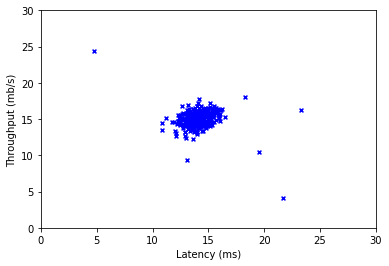

In [12]:
# Visualize the example dataset
plt.scatter(X[:, 0], X[:, 1], c='b', marker='x', s=15)
plt.axis([0, 30, 0, 30])
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')

## Part 2: Estimate the dataset statistics

In [13]:
# Estimate mu and sigma2
mu, sigma2 = estimate_gaussian(X)

In [14]:
mu.ndim

1

In [15]:
# Returns the density of the multivariate normal at each data point(row) of X
p = multivariate_gaussian(X, mu, sigma2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


Text(0, 0.5, 'Throughput (mb/s)')

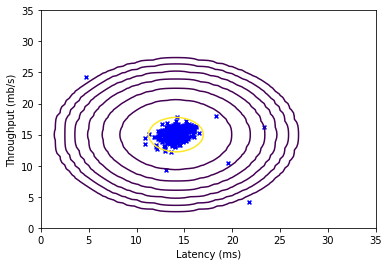

In [16]:
# Visualize the fit
visualize_fit(X, mu, sigma2)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')

## Part 3: Find Outliers

In [17]:
pval = multivariate_gaussian(Xval, mu, sigma2)

In [18]:
epsilon, f1 = select_threshold(yval, pval)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


In [19]:
print('Best epsilon found using cross-validation: {:0.4e}'.format(epsilon))
print('Best F1 on Cross Validation Set: {:0.6f}'.format(f1))
print('(you should see a value epsilon of about 8.99e-05 and F1 of about 0.875)')

Best epsilon found using cross-validation: 8.9909e-05
Best F1 on Cross Validation Set: 0.875000
(you should see a value epsilon of about 8.99e-05 and F1 of about 0.875)


In [20]:
# Find the outliers in the training set and plot
outliers = np.where(p < epsilon)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


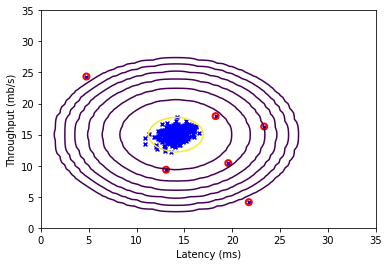

In [21]:
# Draw a red circle around those outliers
visualize_fit(X, mu, sigma2)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.scatter(X[outliers, 0], X[outliers, 1], marker='o', linewidth=2, edgecolors='r', facecolors='none')

## Part 4: Multidimensional Outliers

In [22]:
# Loads the second dataset.
data = scio.loadmat('/content/drive/MyDrive/Coursera_ML/Exer_8/ex8data2.mat')
X, Xval, yval = data['X'], data['Xval'], data['yval'].flatten()

In [23]:
# Apply the same steps to the larger dataset
mu, sigma2 = estimate_gaussian(X)

In [24]:
# Training set
p = multivariate_gaussian(X, mu, sigma2)

In [25]:
# Cross Validation set
pval = multivariate_gaussian(Xval, mu, sigma2)

In [26]:
# Find the best threshold
epsilon, f1 = select_threshold(yval, pval)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


In [27]:
print('Best epsilon found using cross-validation: {:0.4e}'.format(epsilon))
print('Best F1 on Cross Validation Set: {:0.6f}'.format(f1))
print('(you should see a value epsilon of about 1.38e-18')
print('(you should see a Best F1 value of 0.615385)')
print('# Outliers found: {}'.format(np.sum(np.less(p, epsilon))))

Best epsilon found using cross-validation: 1.3772e-18
Best F1 on Cross Validation Set: 0.615385
(you should see a value epsilon of about 1.38e-18
(you should see a Best F1 value of 0.615385)
# Outliers found: 117


In [28]:
X = np.array([[1, 2], [3, 4]])
X * X

array([[ 1,  4],
       [ 9, 16]])

# ex8_cofi

## Part 1: Loading movie ratings dataset

In [29]:
# Load data
data = scio.loadmat('/content/drive/MyDrive/Coursera_ML/Exer_8/ex8_movies.mat')

# Y is a 1682 x 943 2-d ndarray, containing ratings 1-5 of 1682 movies on 943 users
# R is a 1682 x 943 2-d ndarray, where R[i, j] = 1 if and only if user j gave a rating to movie i
Y, R = data['Y'], data['R']

In [30]:
# From the matrix, we can compute statistics like average rating.
print('Average rating for movie 1 (Toy Story): {:0.6f}/5'.format(np.mean(Y[0, np.where(R[0] == 1)])))

Average rating for movie 1 (Toy Story): 3.878319/5


Text(0, 0.5, 'Movies')

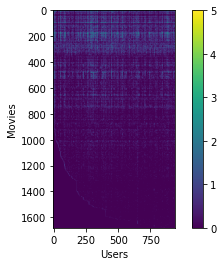

In [31]:
# We can visualize the ratings matrix by plotting it with plt.imshow
plt.imshow(Y)
plt.colorbar()
plt.xlabel('Users')
plt.ylabel('Movies')

## Part 2: Collaborative Filtering Cost Function

In [32]:
# Load pre-trained weights (X, theta, num_users, num_movies, num_features)
data = scio.loadmat('/content/drive/MyDrive/Coursera_ML/Exer_8/ex8_movieParams.mat')
X = data['X']
theta = data['Theta']
num_users = data['num_users']
num_movies = data['num_movies']
num_features = data['num_features']

In [33]:
# Reduce the data set size so that this runs faster
num_users = 4
num_movies = 5
num_features = 3
X = X[:num_movies, :num_features]
theta = theta[:num_users, :num_features]
Y = Y[:num_movies, :num_users]
R = R[:num_movies, :num_users]

In [34]:
# Evaluate cost function
J, grad = cofi_cost_function(np.concatenate((X.flatten(), theta.flatten())), Y, R, num_users, num_movies, num_features, 0)

In [35]:
print('Cost at loaded parameters: {:0.2f}\n(this value should be about 22.22)'.format(J))

Cost at loaded parameters: 22.22
(this value should be about 22.22)


## Part 3: Collaborative Filtering Gradient

In [36]:
# Check gradients by running checkNNGradients
check_cost_function(0)

[[ -0.75453365  -0.75453365]
 [ -0.68237279  -0.68237279]
 [ -0.09625463  -0.09625463]
 [-13.28618465 -13.28618465]
 [ -7.2368227   -7.2368227 ]
 [ 12.77432252  12.77432252]
 [  9.57453645   9.57453645]
 [  8.98778914   8.98778914]
 [-17.02288366 -17.02288366]
 [ -0.73070732  -0.73070732]
 [  1.53605553   1.53605553]
 [ -0.24251079  -0.24251079]
 [  5.92775551   5.92775551]
 [  0.69450487   0.69450487]
 [ -2.13653806  -2.13653806]
 [  5.68731061   5.68731061]
 [  1.44877914   1.44877914]
 [ -2.53046382  -2.53046382]
 [ -1.49019862  -1.49019862]
 [ -3.84619938  -3.84619938]
 [  5.00400015   5.00400015]
 [ 12.10976115  12.10976115]
 [  6.76920935   6.76920935]
 [-11.57307308 -11.57307308]
 [ -2.59957756  -2.59957756]
 [ -5.99085818  -5.99085818]
 [  3.96421995   3.96421995]]
The above two columns you get should be very similar.
(Left-Your Numerical Gradient, Right-Analytical Gradient
If you backpropagation implementation is correct, then
the relative difference will be small (less than 1

## Part 4: Collaborative Filtering Cost Regularization

In [37]:
# Evaluate cost function
J, _ = cofi_cost_function(np.concatenate((X.flatten(), theta.flatten())), Y, R, num_users, num_movies, num_features, 1.5)

In [38]:
print('Cost at loaded parameters (lambda = 1.5): {:0.2f}\n'
      '(this value should be about 31.34)'.format(J))

Cost at loaded parameters (lambda = 1.5): 31.34
(this value should be about 31.34)


## Part 5: Collaborative Filtering Gradient Regularization

In [39]:
check_cost_function(1.5)

[[  0.62956907   0.62956907]
 [  1.30458331   1.30458331]
 [ -8.28764403  -8.28764403]
 [  3.19787239   3.19787239]
 [  7.20054255   7.20054255]
 [ -3.58699588  -3.58699588]
 [ -1.88352333  -1.88352333]
 [ -7.73603583  -7.73603583]
 [  4.36527156   4.36527156]
 [  0.16905282   0.16905282]
 [ 14.79637269  14.79637269]
 [-10.18318379 -10.18318379]
 [  1.21348938   1.21348938]
 [ -0.4740548   -0.4740548 ]
 [  2.19684684   2.19684684]
 [ -1.58190249  -1.58190249]
 [  7.91860398   7.91860398]
 [ -2.76259674  -2.76259674]
 [  3.41962543   3.41962543]
 [ -6.12296997  -6.12296997]
 [  2.19894373   2.19894373]
 [ -2.98761172  -2.98761172]
 [-12.23258091 -12.23258091]
 [  2.50706232   2.50706232]
 [ -0.36148215  -0.36148215]
 [  0.73346322   0.73346322]
 [  4.0461623    4.0461623 ]]
The above two columns you get should be very similar.
(Left-Your Numerical Gradient, Right-Analytical Gradient
If you backpropagation implementation is correct, then
the relative difference will be small (less than 1

## Part 6: Entering ratings for a new user

In [40]:
movie_list = load_movie_list()

In [41]:
# Initialize my ratings
my_ratings = np.zeros(len(movie_list))

In [42]:
# Check the file movie_ids.txt for id of each movie in our dataset
# For example, Toy Story (1995) has ID 0, so to rate it "4", you can set
my_ratings[0] = 4

In [43]:
# Or suppose did not enjoy Silence of the lambs (1991), you can set
my_ratings[97] = 2

In [44]:
# We have selected a few movies we liked / did not like and the ratings we
# gave are as follows:
my_ratings[6] = 3
my_ratings[11] = 5
my_ratings[53] = 4
my_ratings[63] = 5
my_ratings[65] = 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

In [45]:
print('New user ratings:')
for i in range(my_ratings.size):
    if my_ratings[i] > 0:
        print('Rated {} for {}'.format(my_ratings[i], movie_list[i]))

New user ratings:
Rated 4.0 for Toy Story (1995)
Rated 3.0 for Twelve Monkeys (1995)
Rated 5.0 for Usual Suspects, The (1995)
Rated 4.0 for Outbreak (1995)
Rated 5.0 for Shawshank Redemption, The (1994)
Rated 3.0 for While You Were Sleeping (1995)
Rated 5.0 for Forrest Gump (1994)
Rated 2.0 for Silence of the Lambs, The (1991)
Rated 4.0 for Alien (1979)
Rated 5.0 for Die Hard 2 (1990)
Rated 5.0 for Sphere (1998)


## Part 7: Learning Movie Ratings

In [46]:
print('Training collaborative filtering')

Training collaborative filtering


In [47]:
# Load data
data = scio.loadmat('/content/drive/MyDrive/Coursera_ML/Exer_8/ex8_movies.mat')

# Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies by 943 users
# R is a 1682x943 matrix, where R[i,j] = 1 if and only if user j gave a rating to movie i
Y = data['Y']
R = data['R']

In [48]:
# Add our own ratings to the data matrix
Y = np.c_[my_ratings, Y]
R = np.c_[(my_ratings != 0), R]

In [49]:
# Normalize Ratings
Ynorm, Ymean = normalize_ratings(Y, R)

In [50]:
# Useful Values
num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10

In [51]:
# Set Initial Parameters (Theta, X)
X = np.random.randn(num_movies, num_features)
theta = np.random.randn(num_users, num_features)

In [52]:
initial_parameters = np.concatenate([X.flatten(), theta.flatten()])

In [53]:
lmd = 10

In [54]:
def cost_func(p):
    return cofi_cost_function(p, Ynorm, R, num_users, num_movies, num_features, lmd)[0]

In [55]:
def grad_func(p):
    return cofi_cost_function(p, Ynorm, R, num_users, num_movies, num_features, lmd)[1]

In [56]:
theta, *unused = opt.fmin_cg(cost_func, fprime=grad_func, x0=initial_parameters, maxiter=100, disp=False, full_output=True)

In [57]:
# Unfold the returned theta back into U and W
X = theta[:num_movies * num_features].reshape((num_movies, num_features))
theta = theta[num_movies * num_features:].reshape((num_users, num_features))

## Part 8: Recommendation for you

In [58]:
p = np.dot(X, theta.T)
my_predictions = p[:, 0] + Ymean

In [59]:
indices = np.argsort(my_predictions)[::-1]

In [60]:
print('Top recommendation for you:')
for i in range(10):
    j = indices[i]
    print('Predicting rating {:0.1f} for movie {}'.format(my_predictions[j], movie_list[j]))

Top recommendation for you:
Predicting rating 5.0 for movie They Made Me a Criminal (1939)
Predicting rating 5.0 for movie Entertaining Angels: The Dorothy Day Story (1996)
Predicting rating 5.0 for movie Santa with Muscles (1996)
Predicting rating 5.0 for movie Saint of Fort Washington, The (1993)
Predicting rating 5.0 for movie Prefontaine (1997)
Predicting rating 5.0 for movie Marlene Dietrich: Shadow and Light (1996)
Predicting rating 5.0 for movie Someone Else's America (1995)
Predicting rating 5.0 for movie Aiqing wansui (1994)
Predicting rating 5.0 for movie Star Kid (1997)
Predicting rating 5.0 for movie Great Day in Harlem, A (1994)


In [61]:
print('Original ratings provided:')
for i in range(my_ratings.size):
    if my_ratings[i] > 0:
        print('Rated {} for {}'.format(my_ratings[i], movie_list[i]))

Original ratings provided:
Rated 4.0 for Toy Story (1995)
Rated 3.0 for Twelve Monkeys (1995)
Rated 5.0 for Usual Suspects, The (1995)
Rated 4.0 for Outbreak (1995)
Rated 5.0 for Shawshank Redemption, The (1994)
Rated 3.0 for While You Were Sleeping (1995)
Rated 5.0 for Forrest Gump (1994)
Rated 2.0 for Silence of the Lambs, The (1991)
Rated 4.0 for Alien (1979)
Rated 5.0 for Die Hard 2 (1990)
Rated 5.0 for Sphere (1998)
